In [25]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from matplotlib import style

In [26]:
style.use('fivethirtyeight')

In [27]:
import numpy as np
import pandas as pd

In [28]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [66]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import extract

# Database Setup
engine = create_engine('sqlite:///hawaii.sqlite')

In [30]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [31]:
# We can view all of the classes that automap found
# reference the classes that were mapped in each table
Base.classes.keys()

['measurement', 'station']

In [32]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [33]:
# Create our session (link) from Python to the DB (Session to query our database and query for data)
session = Session(engine)

# Exploratory Climate Analysis

[('2016-08-23', 0.0), ('2016-08-24', 0.08), ('2016-08-25', 0.08), ('2016-08-26', 0.0), ('2016-08-27', 0.0), ('2016-08-28', 0.01), ('2016-08-29', 0.0), ('2016-08-30', 0.0), ('2016-08-31', 0.13), ('2016-09-01', 0.0), ('2016-09-02', 0.0), ('2016-09-03', 0.0), ('2016-09-04', 0.03), ('2016-09-05', None), ('2016-09-06', None), ('2016-09-07', 0.05), ('2016-09-08', 0.0), ('2016-09-09', 0.03), ('2016-09-10', 0.0), ('2016-09-11', 0.05), ('2016-09-12', 0.0), ('2016-09-13', 0.02), ('2016-09-14', 1.32), ('2016-09-15', 0.42), ('2016-09-16', 0.06), ('2016-09-17', 0.05), ('2016-09-18', 0.0), ('2016-09-19', 0.0), ('2016-09-20', 0.0), ('2016-09-21', 0.0), ('2016-09-22', 0.02), ('2016-09-23', 0.0), ('2016-09-24', 0.0), ('2016-09-25', 0.0), ('2016-09-26', 0.06), ('2016-09-27', 0.02), ('2016-09-28', 0.0), ('2016-09-29', 0.0), ('2016-09-30', 0.0), ('2016-10-01', 0.0), ('2016-10-02', 0.0), ('2016-10-03', 0.0), ('2016-10-04', 0.0), ('2016-10-05', 0.0), ('2016-10-06', 0.0), ('2016-10-07', 0.0), ('2016-10-08', 

Text(0, 0.5, 'Precipitation (in)')

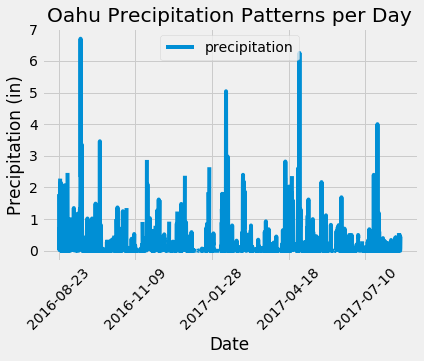

In [34]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.

#Starting from the last data point in the database. 

# Calculate the date one year from the last date in data set.
prev_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# PRECIPITATION ANALYSIS
# Perform a query to retrieve the data and precipitation scores
results = []
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= prev_year).all()
print(results)

# Save the query results as a Pandas DataFrame and set the index to the date column
# DataFrames allow for repeating the process of wanting to run the analysis again if needed
# To save- provide results variable as one parameter and specify column names as second parameter
df = pd.DataFrame(results, columns=['date','precipitation'])

# Sort the dataframe by date. Set index column to date (first) column
df.set_index(df['date'], inplace=True)
df = df.sort_index()
# Set dates into chrnological order
print(df.to_string(index=False))

# Use Pandas Plotting with Matplotlib to plot the precipitation data per day
df.plot()
plt.xticks(rotation=45)
plt.title("Oahu Precipitation Patterns per Day")
plt.xlabel('Date')
plt.ylabel('Precipitation (in)')

In [35]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [36]:
# STATION ANALYSIS
# Using SQLite database to run a query for:
# How many stations are available in this dataset?
session.query(func.count(Station.station)).all()

[(9)]

In [37]:
# What are the most active stations (# of recordings) out of the nine?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [38]:
# TEMPERATURE ANALYSIS
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).all()

[(53.0, 87.0, 73.09795396419437)]

In [39]:
# Choose the station with the highest number of temperature observations.
# temperature stats for station with most recorded measurements
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

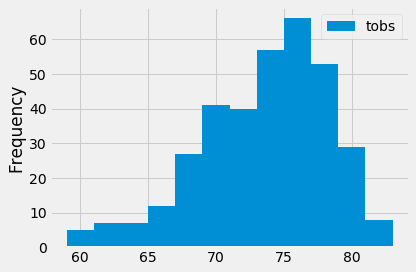

In [40]:
# Query the last 12 months of temperature observation data for this station
# Plot the results as a histogram (data seperated into bins ~5-20)
results = session.query(Measurement.tobs).\
filter(Measurement.station == 'USC00519281').\
filter(Measurement.date >= prev_year).all()

# Convert results into a DataFrame
df = pd.DataFrame(results, columns=['tobs'])
df.plot.hist(bins=12)
plt.tight_layout() # is used to compress x-axis labels to fit into the box holding the plot

In [59]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_stats(start='06-04-2017', end='06-30-17'):
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    if not end:
        results = session.query(*sel).filter(Measurement.date >= start).all()
        temps = list(np.ravel(results))
        return temps
    print(results)

In [60]:
temps_df = pd.DataFrame(results, columns=['temps'])
temps_df

,temps
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0
...,...
347,77.0
348,77.0
349,76.0
350,76.0


# Challenge

In [61]:
# Find Oahu's seasonal weather data 
# The goals of this challenge are for you to:

# Determine key statistical data about the month of June.
# Compare your findings between the month of June and December.
# Make 2 or 3 recommendations for further analysis.
# Share your findings in the Jupyter Notebook.

In [110]:
# Find weather data for June across stations using describe() function 
june_data = session.query(Measurement.date, Measurement.tobs, Measurement.prcp).filter(extract('month', Measurement.date) == 6).all()
june_df = pd.DataFrame(june_data, columns = ['Date', 'Avg Temperature','Precipitation(in)'])
june_df.describe()

,Avg Temperature,Precipitation(in)
count,1700.000000,1574.000000
mean,74.944118,0.136360
std,3.257417,0.335731
min,64.000000,0.000000
25%,73.000000,0.000000
50%,75.000000,0.020000
75%,77.000000,0.120000
max,85.000000,4.430000


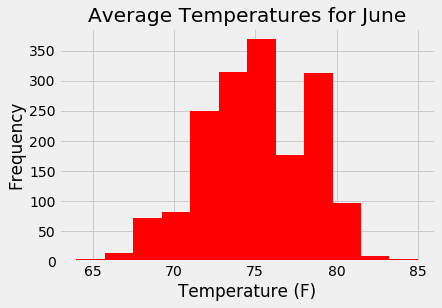

In [133]:
# Avg Temperature for June (all years and stations)
june_df["Avg Temperature"].plot.hist(bins=12, color="red") 
plt.xlabel('Temperature (F)')
plt.title('Average Temperatures for June')
plt.savefig(r'C:\Users\User1\Desktop\Surfs_up\june_temp.png', dpi=300, bbox_inches='tight')

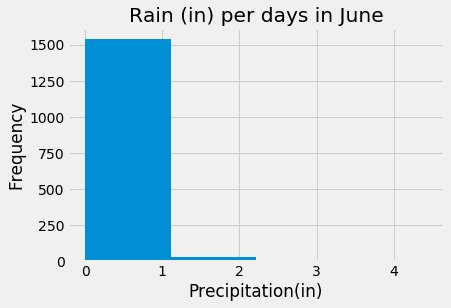

In [132]:
# Rain per day in June (all years and stations)
june_df["Precipitation(in)"].plot.hist(bins=4)
plt.xlabel('Precipitation(in)')
plt.title('Rain (in) per days in June')
plt.savefig(r'C:\Users\User1\Desktop\Surfs_up\june_rain.png', dpi=300, bbox_inches='tight')

In [108]:
# Find weather data for December across all stations and years using describe() function 
december_data = session.query(Measurement.date, Measurement.tobs, Measurement.prcp).filter(extract('month', Measurement.date) == 12).all()
december_df = pd.DataFrame(december_data, columns = ['Date', 'Avg Temperature','Precipitation(in)']) 
december_df.describe()

,Avg Temperature,Precipitation(in)
count,1517.000000,1405.000000
mean,71.041529,0.216819
std,3.745920,0.541399
min,56.000000,0.000000
25%,69.000000,0.000000
50%,71.000000,0.030000
75%,74.000000,0.150000
max,83.000000,6.420000


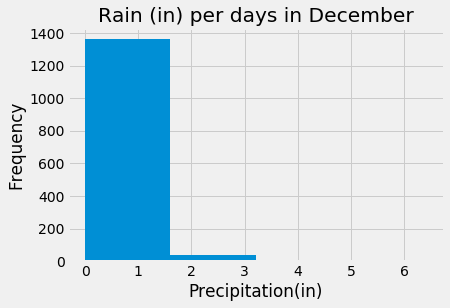

In [128]:
# Rain per days in December (all years and stations)
december_df["Precipitation(in)"].plot.hist(bins=4)
plt.xlabel('Precipitation(in)')
plt.title('Rain (in) per days in December')
plt.savefig(r'C:\Users\User1\Desktop\Surfs_up\december_rain.png', dpi=300, bbox_inches='tight')

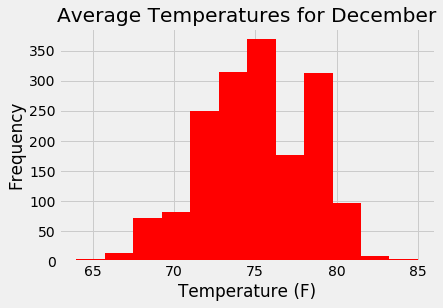

In [130]:
# Avg Temperature for December (all years and stations)
june_df["Avg Temperature"].plot.hist(bins=12, color="red") 
plt.xlabel('Temperature (F)')
plt.title('Average Temperatures for December')
plt.savefig(r'C:\Users\User1\Desktop\Surfs_up\december_temp.png', dpi=300, bbox_inches='tight')

In [ ]:
# Analysis and Recommendations on README